<a href="https://colab.research.google.com/github/rounaksaha12/Graph-Clustering/blob/main/GNN_citations_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir graph_info

In [2]:
!mkdir outputs

In [18]:
!pip install scipy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [105]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 KB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 64.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [20]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric

1.13.0+cu116
11.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 1.1 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=cec462d0e83c4557de13fe2c67933768d0229df4b409640c3ecb5c5749c21335
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
S

In [1]:
import time
import numpy as np
import pandas as pd
import networkx as nx

In [2]:
intended_cluster_count=9 #choosing cluster count with highest silhoutte index

cluster_assignments_df=pd.read_csv(f'./outputs/cluster_assignments_ncluster_{intended_cluster_count}.csv')
cluster_labels=cluster_assignments_df.to_numpy()[:,1]
node_count=len(cluster_labels)
print(node_count)
print(cluster_labels)

2114
[2 7 3 ... 2 5 3]


In [3]:
mapped_edge_list=pd.read_csv('./graph_info/edge_info.txt',delimiter='\t').to_numpy()
mapped_edge_list

array([[   0,  140],
       [   1, 1630],
       [   2, 1038],
       ...,
       [2027, 2047],
       [2027, 2050],
       [2059, 2079]])

In [4]:
G_mapped=nx.Graph()
G_mapped.add_nodes_from(np.arange(node_count))
G_mapped.add_edges_from(mapped_edge_list)

In [5]:
print(G_mapped.number_of_nodes())
print(G_mapped.number_of_edges())

2114
2160


In [9]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

In [8]:
adj = nx.to_scipy_sparse_array(G_mapped).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

In [10]:
# custom dataset
class CitationsDataset(InMemoryDataset):
    def __init__(self, G, edge_index, num_classes, cluster_labels,transform=None):
        super(CitationsDataset, self).__init__('.', transform, None, None)
        data = Data(edge_index=edge_index)
        n_nodes = G.number_of_nodes()
        data.num_nodes = n_nodes
        
        # input feature: node id
        data.x = torch.arange(n_nodes)
        
        # labels
        y = torch.from_numpy(cluster_labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = num_classes

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())), 
                                                            pd.Series(cluster_labels),
                                                            test_size=0.50, 
                                                            random_state=42)
        
        
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [12]:
num_classes=np.argmax(cluster_labels)+1
citations_data=CitationsDataset(G_mapped,edge_index,num_classes,cluster_labels)[0]
# print(citations_dataset)

In [13]:
class Net(nn.Module):
      def __init__(self,num_nodes,num_classes,embed_dim=32):
          super(Net,self).__init__()
          self.num_nodes=num_nodes
          self.embed_dim=embed_dim
          self.embed=nn.Embedding(num_nodes,embed_dim)
          self.conv1=GCNConv(embed_dim,64)
          self.conv2=GCNConv(64,int(num_classes))

      def forward(self,x,edge_index):
          x=self.embed(x)
          x=F.relu(self.conv1(x,edge_index))
          x = F.dropout(x, training=self.training)
          x = self.conv2(x, edge_index)
          return F.log_softmax(x, dim=1)

      def decode(self,x,edge_index):
          x=F.relu(self.conv1(x,edge_index))
          x = F.dropout(x, training=self.training)
          x = self.conv2(x, edge_index)
          return F.log_softmax(x, dim=1)



In [14]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
citations_data=citations_data.to(device)
model=Net(node_count,num_classes,2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2, weight_decay=5e-4)

In [15]:
from tqdm import tqdm

In [16]:
epoch_cnt=500

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

t_start = time.time()

# train loop
for epoch in tqdm(range(epoch_cnt)):
    t = time.time()

    model.train()
    optimizer.zero_grad()
    
    output = model(citations_data.x,edge_index)
    loss_train = F.nll_loss(output[citations_data.train_mask], citations_data.y[citations_data.train_mask])
    acc_train = accuracy(output[citations_data.train_mask], citations_data.y[citations_data.train_mask])
    
    loss_train.backward()
    
    optimizer.step()
    
    model.eval()
    output = model(citations_data.x,edge_index)
    
    loss_val = F.nll_loss(output[citations_data.test_mask], citations_data.y[citations_data.test_mask])
    acc_val = accuracy(output[citations_data.test_mask], citations_data.y[citations_data.test_mask])
    
    if not epoch % 10:
      # Print all the results and the time required
      print('Epoch: {:04d}'.format(epoch+1),
            'loss_train: {:.4f}'.format(loss_train.item()),
            'acc_train: {:.4f}'.format(acc_train.item()),
            'loss_val: {:.4f}'.format(loss_val.item()),
            'acc_val: {:.4f}'.format(acc_val.item()),
            'time: {:.4f}s'.format(time.time() - t))
    
print("Model training is complete!")
print("Total model training time: {:.4f}s".format(time.time() - t_start))

  2%|▏         | 12/500 [00:00<00:08, 55.65it/s]

Epoch: 0001 loss_train: 2.4876 acc_train: 0.1022 loss_val: 2.4527 acc_val: 0.1429 time: 0.0366s
Epoch: 0011 loss_train: 2.2693 acc_train: 0.1731 loss_val: 2.2581 acc_val: 0.1722 time: 0.0170s


  6%|▌         | 31/500 [00:00<00:08, 58.62it/s]

Epoch: 0021 loss_train: 2.1404 acc_train: 0.2110 loss_val: 2.1429 acc_val: 0.2034 time: 0.0149s
Epoch: 0031 loss_train: 2.0357 acc_train: 0.2507 loss_val: 2.0569 acc_val: 0.2403 time: 0.0160s


 10%|▉         | 49/500 [00:00<00:08, 55.14it/s]

Epoch: 0041 loss_train: 1.8618 acc_train: 0.3160 loss_val: 1.9079 acc_val: 0.3236 time: 0.0163s
Epoch: 0051 loss_train: 1.5913 acc_train: 0.4513 loss_val: 1.6661 acc_val: 0.4229 time: 0.0157s


 13%|█▎        | 67/500 [00:01<00:07, 55.54it/s]

Epoch: 0061 loss_train: 1.3172 acc_train: 0.5289 loss_val: 1.3842 acc_val: 0.5459 time: 0.0156s
Epoch: 0071 loss_train: 0.9986 acc_train: 0.6755 loss_val: 1.1425 acc_val: 0.6329 time: 0.0146s


 19%|█▊        | 93/500 [00:01<00:06, 60.14it/s]

Epoch: 0081 loss_train: 0.7856 acc_train: 0.7606 loss_val: 0.9615 acc_val: 0.7162 time: 0.0160s
Epoch: 0091 loss_train: 0.5916 acc_train: 0.8439 loss_val: 0.8272 acc_val: 0.7578 time: 0.0145s


 21%|██▏       | 107/500 [00:01<00:06, 59.96it/s]

Epoch: 0101 loss_train: 0.4435 acc_train: 0.8912 loss_val: 0.7327 acc_val: 0.7862 time: 0.0183s
Epoch: 0111 loss_train: 0.3114 acc_train: 0.9262 loss_val: 0.6741 acc_val: 0.8136 time: 0.0201s


 25%|██▌       | 127/500 [00:02<00:06, 58.56it/s]

Epoch: 0121 loss_train: 0.2567 acc_train: 0.9432 loss_val: 0.6278 acc_val: 0.8325 time: 0.0179s
Epoch: 0131 loss_train: 0.2012 acc_train: 0.9603 loss_val: 0.6050 acc_val: 0.8420 time: 0.0146s


 30%|███       | 152/500 [00:02<00:05, 58.40it/s]

Epoch: 0141 loss_train: 0.1677 acc_train: 0.9650 loss_val: 0.5872 acc_val: 0.8534 time: 0.0167s
Epoch: 0151 loss_train: 0.1364 acc_train: 0.9773 loss_val: 0.5717 acc_val: 0.8638 time: 0.0145s


 34%|███▍      | 171/500 [00:02<00:05, 58.85it/s]

Epoch: 0161 loss_train: 0.1044 acc_train: 0.9839 loss_val: 0.5600 acc_val: 0.8600 time: 0.0148s
Epoch: 0171 loss_train: 0.1058 acc_train: 0.9858 loss_val: 0.5467 acc_val: 0.8647 time: 0.0151s


 38%|███▊      | 190/500 [00:03<00:05, 59.02it/s]

Epoch: 0181 loss_train: 0.0822 acc_train: 0.9905 loss_val: 0.5180 acc_val: 0.8704 time: 0.0163s
Epoch: 0191 loss_train: 0.0729 acc_train: 0.9934 loss_val: 0.4987 acc_val: 0.8780 time: 0.0157s


 42%|████▏     | 208/500 [00:03<00:05, 58.15it/s]

Epoch: 0201 loss_train: 0.0720 acc_train: 0.9943 loss_val: 0.4871 acc_val: 0.8789 time: 0.0161s
Epoch: 0211 loss_train: 0.0663 acc_train: 0.9972 loss_val: 0.4672 acc_val: 0.8817 time: 0.0149s


 46%|████▋     | 232/500 [00:04<00:04, 57.35it/s]

Epoch: 0221 loss_train: 0.0629 acc_train: 0.9934 loss_val: 0.4461 acc_val: 0.8884 time: 0.0200s
Epoch: 0231 loss_train: 0.0594 acc_train: 0.9981 loss_val: 0.4269 acc_val: 0.8950 time: 0.0155s


 50%|█████     | 251/500 [00:04<00:04, 58.17it/s]

Epoch: 0241 loss_train: 0.0570 acc_train: 0.9962 loss_val: 0.4075 acc_val: 0.8978 time: 0.0148s
Epoch: 0251 loss_train: 0.0470 acc_train: 0.9981 loss_val: 0.3855 acc_val: 0.9007 time: 0.0149s


 54%|█████▍    | 271/500 [00:04<00:03, 59.67it/s]

Epoch: 0261 loss_train: 0.0471 acc_train: 0.9962 loss_val: 0.3725 acc_val: 0.9035 time: 0.0147s
Epoch: 0271 loss_train: 0.0470 acc_train: 0.9991 loss_val: 0.3566 acc_val: 0.9149 time: 0.0148s


 58%|█████▊    | 291/500 [00:05<00:03, 60.35it/s]

Epoch: 0281 loss_train: 0.0417 acc_train: 0.9991 loss_val: 0.3439 acc_val: 0.9149 time: 0.0147s
Epoch: 0291 loss_train: 0.0444 acc_train: 0.9962 loss_val: 0.3179 acc_val: 0.9385 time: 0.0150s


 62%|██████▏   | 312/500 [00:05<00:03, 59.56it/s]

Epoch: 0301 loss_train: 0.0474 acc_train: 0.9972 loss_val: 0.3102 acc_val: 0.9300 time: 0.0147s
Epoch: 0311 loss_train: 0.0400 acc_train: 1.0000 loss_val: 0.3045 acc_val: 0.9376 time: 0.0150s


 67%|██████▋   | 333/500 [00:05<00:02, 60.60it/s]

Epoch: 0321 loss_train: 0.0420 acc_train: 1.0000 loss_val: 0.2839 acc_val: 0.9480 time: 0.0147s
Epoch: 0331 loss_train: 0.0422 acc_train: 1.0000 loss_val: 0.2757 acc_val: 0.9432 time: 0.0147s


 69%|██████▉   | 347/500 [00:05<00:02, 60.64it/s]

Epoch: 0341 loss_train: 0.0404 acc_train: 1.0000 loss_val: 0.2661 acc_val: 0.9555 time: 0.0174s
Epoch: 0351 loss_train: 0.0410 acc_train: 0.9991 loss_val: 0.2606 acc_val: 0.9536 time: 0.0149s


 74%|███████▎  | 368/500 [00:06<00:02, 61.28it/s]

Epoch: 0361 loss_train: 0.0419 acc_train: 1.0000 loss_val: 0.2542 acc_val: 0.9650 time: 0.0146s
Epoch: 0371 loss_train: 0.0394 acc_train: 0.9991 loss_val: 0.2556 acc_val: 0.9622 time: 0.0148s


 78%|███████▊  | 388/500 [00:06<00:01, 60.37it/s]

Epoch: 0381 loss_train: 0.0390 acc_train: 0.9991 loss_val: 0.2411 acc_val: 0.9659 time: 0.0149s
Epoch: 0391 loss_train: 0.0412 acc_train: 0.9991 loss_val: 0.2385 acc_val: 0.9678 time: 0.0146s


 82%|████████▏ | 409/500 [00:06<00:01, 61.20it/s]

Epoch: 0401 loss_train: 0.0366 acc_train: 0.9991 loss_val: 0.2322 acc_val: 0.9697 time: 0.0153s
Epoch: 0411 loss_train: 0.0393 acc_train: 1.0000 loss_val: 0.2235 acc_val: 0.9716 time: 0.0150s


 86%|████████▌ | 430/500 [00:07<00:01, 60.89it/s]

Epoch: 0421 loss_train: 0.0402 acc_train: 1.0000 loss_val: 0.2227 acc_val: 0.9754 time: 0.0152s
Epoch: 0431 loss_train: 0.0415 acc_train: 0.9981 loss_val: 0.2215 acc_val: 0.9745 time: 0.0228s


 90%|█████████ | 451/500 [00:07<00:00, 60.78it/s]

Epoch: 0441 loss_train: 0.0435 acc_train: 0.9991 loss_val: 0.2188 acc_val: 0.9754 time: 0.0177s
Epoch: 0451 loss_train: 0.0354 acc_train: 1.0000 loss_val: 0.2166 acc_val: 0.9763 time: 0.0146s


 94%|█████████▍| 472/500 [00:08<00:00, 58.76it/s]

Epoch: 0461 loss_train: 0.0366 acc_train: 1.0000 loss_val: 0.2167 acc_val: 0.9773 time: 0.0165s
Epoch: 0471 loss_train: 0.0381 acc_train: 0.9981 loss_val: 0.2163 acc_val: 0.9773 time: 0.0161s


 98%|█████████▊| 491/500 [00:08<00:00, 59.58it/s]

Epoch: 0481 loss_train: 0.0357 acc_train: 0.9991 loss_val: 0.2129 acc_val: 0.9773 time: 0.0153s
Epoch: 0491 loss_train: 0.0355 acc_train: 1.0000 loss_val: 0.2121 acc_val: 0.9811 time: 0.0167s


100%|██████████| 500/500 [00:08<00:00, 58.82it/s]

Model training is complete!
Total model training time: 8.5089s


Plotting the embedding space

Parameter containing:
tensor([[ 0.3675, -0.1909],
        [-0.3695,  0.0448],
        [ 0.0451,  0.0972],
        ...,
        [ 0.0786, -0.0733],
        [-0.0640,  0.1566],
        [ 0.1153,  0.2788]], requires_grad=True)


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


[[8. 8. 8. ... 7. 7. 7.]
 [8. 8. 8. ... 7. 7. 7.]
 [8. 8. 8. ... 7. 7. 7.]
 ...
 [2. 2. 2. ... 0. 3. 3.]
 [2. 2. 2. ... 0. 0. 3.]
 [2. 2. 2. ... 0. 0. 0.]]


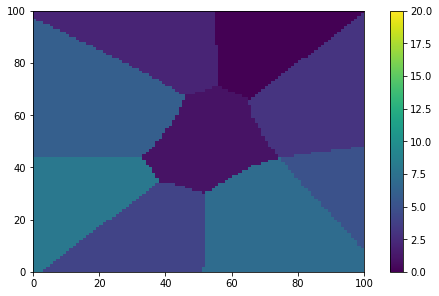

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_examples(color_mat,colormaps):
    """
    Helper function to plot color_mat with associated colormap.
    """    
    fig, axs = plt.subplots(constrained_layout=True, squeeze=False)
    ax=axs.flat[0]
    cmap=colormaps
    psm = ax.pcolormesh(color_mat, cmap=cmap, rasterized=True, vmin=0, vmax=20)
    fig.colorbar(psm, ax=ax)
    plt.savefig('graph.jpeg')

for embedding_mat in model.embed.parameters():
  print(embedding_mat)
  max_x=torch.max(embedding_mat[:,0]).detach()
  min_x=torch.min(embedding_mat[:,0]).detach()
  max_y=torch.max(embedding_mat[:,1]).detach()
  min_y=torch.min(embedding_mat[:,1]).detach()

grid_size=100
x_step=(max_x-min_x)/grid_size
y_step=(max_y-min_y)/grid_size
color_mat=np.empty((grid_size,grid_size))


for i in tqdm(range(grid_size)):
  for j in tqdm(range(grid_size)):
    emb_x=min_x+x_step*i
    emb_y=min_y+y_step*j
    dummy_input=torch.zeros((node_count,2),dtype=torch.float32)
    dummy_input[0][0]=emb_x
    dummy_input[0][1]=emb_y
    color_mat[i][j]=torch.argmax(model.decode(dummy_input,edge_index)[0]).item()

print(color_mat)

viridis = mpl.colormaps['viridis'].resampled(256)
plot_examples(color_mat,viridis)